In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jesperdramsch/siim-acr-pneumothorax-segmentation-data -p /content/kaggle/

Dataset URL: https://www.kaggle.com/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data
License(s): unknown
100% 3.03G/3.03G [00:43<00:00, 95.1MB/s]
100% 3.03G/3.03G [00:43<00:00, 74.3MB/s]


In [ ]:
!unzip /content/kaggle/siim-acr-pneumothorax-segmentation-data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2137.1517875171.310659/1.2.276.0.7230010.3.1.3.8323329.2137.1517875171.310658/1.2.276.0.7230010.3.1.4.8323329.2137.1517875171.310660.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2138.1517875171.323419/1.2.276.0.7230010.3.1.3.8323329.2138.1517875171.323418/1.2.276.0.7230010.3.1.4.8323329.2138.1517875171.323420.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2139.1517875171.325963/1.2.276.0.7230010.3.1.3.8323329.2139.1517875171.325962/1.2.276.0.7230010.3.1.4.8323329.2139.1517875171.325964.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2140.1517875171.331423/1.2.276.0.7230010.3.1.3.8323329.2140.1517875171.331422/1.2.276.0.7230010.3.1.4.8323329.2140.1517875171.331424.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2

In [ ]:
!pip install pylibjpeg

In [ ]:
!pip install pyjpegls

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.3 MB/s eta 0:00:00


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.9 MB/s eta 0:00:00


In [ ]:
!pip install python-gdcm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 50.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
from pathlib import Path
import pylibjpeg
# import pyjpegls
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm.notebook import tqdm

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Загрузка меток (labels)
# Загрузим CSV файл с метками и удалим дубликаты
labels_df = pd.read_csv('/content/train-rle.csv')



In [ ]:
# Проверяем количество записей и уникальных изображений
print(f"Всего записей: {labels_df['ImageId'].count()}, из них уникальных {labels_df['ImageId'].value_counts().shape[0]}")


Всего записей: 11582, из них уникальных 10675


In [ ]:
# Удаляем дубликаты по столбцу ImageId
labels_df = labels_df.drop_duplicates('ImageId')
print(f"Размер данных после удаления дубликатов: {labels_df.shape}")

Размер данных после удаления дубликатов: (10675, 2)


In [ ]:
labels_df.shape

(10675, 2)

In [ ]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10675 entries, 0 to 11581
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ImageId         10675 non-null  object
 1    EncodedPixels  10675 non-null  object
dtypes: object(2)
memory usage: 250.2+ KB


In [ ]:
# Переименовываем столбцы
labels_df.columns = ['ImageId', 'Target']


In [ ]:
# Заменяем значения в столбце 'Target': 1 для наличия пневмоторакса, 0 для его отсутствия
labels_df.loc[labels_df['Target'] != ' -1', 'Target'] = 1
labels_df.loc[labels_df['Target'] == ' -1', 'Target'] = 0

# Преобразуем тип данных столбца 'Target' в int64
labels_df['Target'] = labels_df['Target'].astype('int64')

# Выводим информацию о DataFrame для проверки
print(labels_df.info())
print(labels_df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 10675 entries, 0 to 11581
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  10675 non-null  object
 1   Target   10675 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.2+ KB
None
                                             ImageId  Target
0  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...       0
1  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...       0
2  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...       1
3  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...       1
7  1.2.276.0.7230010.3.1.4.8323329.1314.151787516...       1


In [ ]:
# Указываем путь к DICOM файлам
from pathlib import Path
ROOT_PATH = Path("/content/dicom-images-train")
SAVE_PATH = Path("/content/Processed/train_or_val/")

In [ ]:

# Получаем все пути к DICOM файлам
all_train_dcm = list(ROOT_PATH.rglob("*/*/*.*"))

# Изменяем функцию, чтобы найти правильный DICOM файл по ImageId
def preprocess_images(image_id, image_size=(256, 256)):
    # Находим соответствующий путь к файлу по ImageId
    dicom_path = [str(path) for path in all_train_dcm if image_id in str(path)]

    if not dicom_path:
        raise FileNotFoundError(f"Файл не найден для ImageId: {image_id}")

    # Загружаем первый найденный DICOM файл
    dicom = pydicom.dcmread(dicom_path[0])

    # Предобрабатываем DICOM файл
    img = dicom.pixel_array
    img = cv2.resize(img, image_size)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    return img

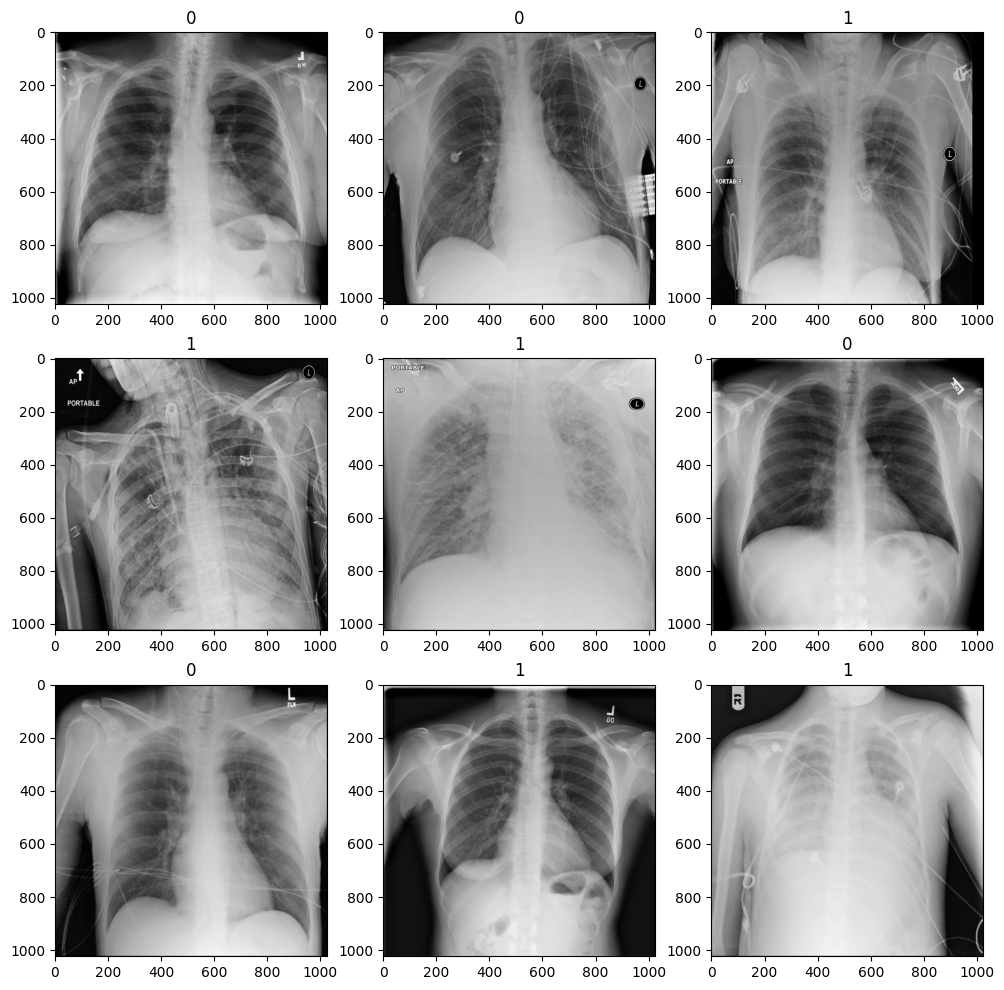

In [ ]:
# Для начала создадим объекты fig и axis и используем функцию plt.subplots,
# введем число строк и столбцов, а также зададим размер изображения  12x12
fig, axis = plt.subplots(3, 3, figsize=(12, 12))
# Создадим переменную - счетчик циклов с исходным значением 0
c = 0
# Создадим вложенный цикл: внешний - итерации по строкам, внутренний - по столбцам
for i in range(3):
    for j in range(3):
        # В функцию read_file передаем путь к файлу и получаем массив пикселей dicom файла
        dcm = pydicom.dcmread(all_train_dcm[c]).pixel_array

        # Сохраним значение таргета в переменной label
        label_df = labels_df['Target'].iloc[c]

        # Воспользуемся функцией imshow для отображения массива пикселей.
        # Значение color map установим 'bone' или 'gray'
        axis[i][j].imshow(dcm, cmap='gray')

        # В качестве заголовка просто установим значение таргета
        axis[i][j].set_title(label_df)
        # Увеличим значение счетчика
        c+=1

In [ ]:
# Присоединяем пути к изображениям
labels_df['ImagePath'] = labels_df['ImageId'].apply(lambda x: f'/content/dicom-images-train{x}.dcm')

# Разделяем данные на обучающую и валидационную выборки (80% на обучение и 20% на валидацию) - Обучающая выборка будет использована для тренировки модели, валидационная — для оценки её точности на новых данных.
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

In [ ]:
# Загружаем предобученную модель VGG16 без верхних слоев (top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Добавляем кастомные слои поверх VGG16
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Выходной слой для бинарной классификации (пневмоторакс/нет)


In [ ]:
# Определяем модель
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
# Замораживаем веса базовой модели (VGG16), чтобы не обновлять их во время обучения
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Компилируем модель с оптимизатором Adam - на этом этапе модель настраивается для оптимизации и оценки, и выбираются такие ключевые элементы,
# как функция потерь, оптимизатор и метрики.
# Используем оптимизатор Adam с малым шагом обучения (скорость обучения (learning_rate) контролирует, как сильно изменяются веса модели при каждой итерации.)
# Функция потерь для бинарной классификации
# Оценочная метрика — точность
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Шаг 6: Аугментация данных
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Генераторы данных для обучения и валидации
def generator(df, batch_size, is_train=True):
    datagen = train_datagen if is_train else val_datagen
    while True:
        for start in range(0, len(df), batch_size):
            batch_df = df.iloc[start:start+batch_size]
            batch_images = np.array([preprocess_images(img_id) for img_id in batch_df['ImageId']])
            batch_labels = batch_df['Target'].values
            yield datagen.flow(batch_images, batch_labels, batch_size=batch_size).__next__()

train_generator = generator(train_df, batch_size=16)
val_generator = generator(val_df, batch_size=16, is_train=False)

In [ ]:
# Шаг 7: Обучение модели
# Callback для сохранения модели с наилучшей валидационной точностью
# Обучение модели
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    steps_per_epoch=len(train_df) // 16,
    validation_steps=len(val_df) // 16)#,
#     callbacks=[checkpoint]
# )

533/533 ━━━━━━━━━━━━━━━━━━━━ 10056s 19s/step - accuracy: 0.7240 - loss: 2.0242 - val_accuracy: 0.7773 - val_loss: 0.4814


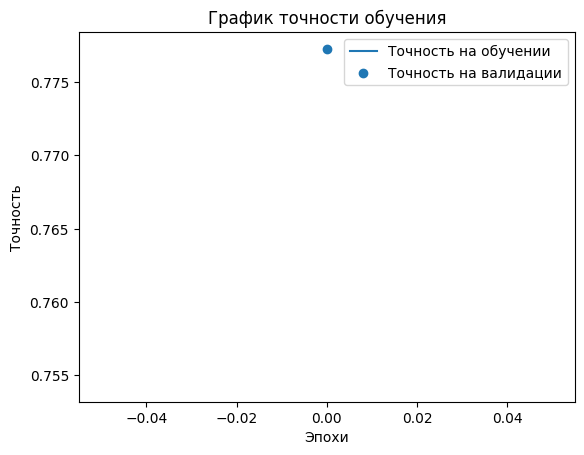

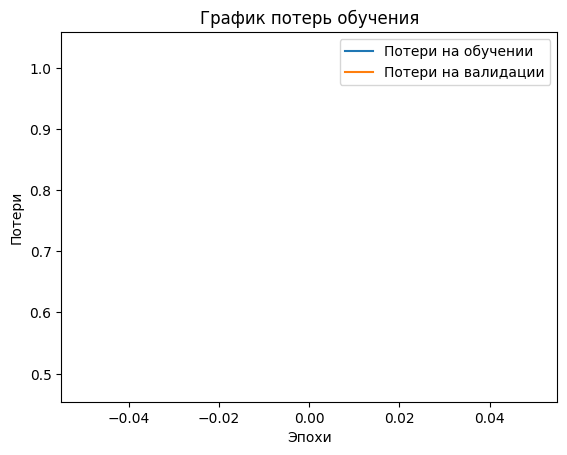

In [ ]:
# Шаг 8: Построение графиков обучения
# График точности
epochs_ = range(0,1)
plt.plot(epochs_, history.history['accuracy'], label='Точность на обучении')
plt.scatter(epochs_, history.history['val_accuracy'], label='Точность на валидации')
plt.title('График точности обучения')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

# График потерь
plt.plot(epochs_, history.history['loss'], label='Потери на обучении')
plt.plot(epochs_, history.history['val_loss'], label='Потери на валидации')
plt.title('График потерь обучения')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 1904s 28s/step


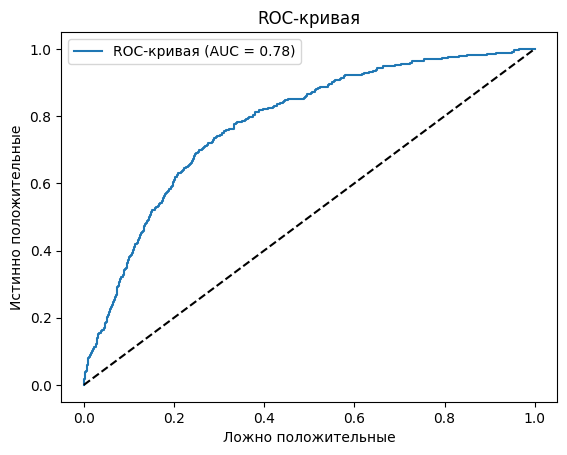

In [ ]:
# Шаг 9: Оценка модели на валидационной выборке и построение ROC-кривой
from sklearn.metrics import roc_curve, auc

# Предсказания для валидационного набора
val_images = np.array([preprocess_images(img_id) for img_id in val_df['ImageId']])
val_labels = val_df['Target'].values
val_preds = model.predict(val_images)

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-кривая')
plt.xlabel('Ложно положительные')
plt.ylabel('Истинно положительные')
plt.legend()
plt.show()

In [ ]:
# Шаг 10: Определение оптимального порога (threshold)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = _[optimal_idx]
print(f'Оптимальный порог для классификации: {optimal_threshold}')

Оптимальный порог для классификации: 0.14429117739200592
